### Analysis of variation between individuals
1. Normalization is done using DESeq2 (vst) and will be used for other analysis - linear regression
2. Principal component analysis to identify source of variation
3. Consistency (correlation) of replicates from the same individual


In [2]:
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(gplots))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(goseq))
suppressPackageStartupMessages(library(Hmisc))
suppressPackageStartupMessages(library(scatterplot3d))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(vioplot))
suppressPackageStartupMessages(library(beeswarm))

### Normalization
the output is going in the peakcalling folder and in the PCA folders

In [67]:
home       = '/home/paola/Family1070/private_output/PCA_chipseq'
dir_counts = '/frazer01/home/paola/Family1070/private_output/PeakCalling'
marks      =  list.files(dir_counts)
setwd(home)

In [68]:
marks =c('H3K27AC_CM', 'H3K27AC_IPSC', 'NKX25')

In [25]:
tables=paste(dir_counts,marks,'meta_macs2_callPeak_peaks.q001.narrowPeak.collapse.noXY.counts', sep="/")
outfiles=paste(dir_counts,marks, "meta_macs2_callPeak_peaks.q001.narrowPeak.collapse.noXY.normalized.counts" , sep="/")
metadata= read.csv("../PCA_chipseq/fam1070_data_plus_production-v3.csv")

In [26]:
metadata$data_cell = paste(metadata$Cell_type, metadata$Data_type, sep="_")
avg = aggregate(cbind(Uniquely_mapped_and_filtered_reads,ChIP.Seq_ATAC.Seq_number_of_peaks,ChIP.Seq_ATAC.Seq_FRiP)~data_cell,
                metadata,mean)
stdev = aggregate(cbind(Uniquely_mapped_and_filtered_reads,ChIP.Seq_ATAC.Seq_number_of_peaks,ChIP.Seq_ATAC.Seq_FRiP)~data_cell,
                metadata,sd)

In [92]:
for (i in 1:length(marks)){
cat(marks[i])
mat    = read.table(tables[i],header=T, row.names=1, check.names=F)
ta.sub = mat[, c(6:length(mat))]

group = subset(metadata, UUID %in% colnames(ta.sub) )

ta.sub=subset(ta.sub, select=as.character(group$UUID)) ### ensure the order

ta.sub=round(ta.sub,0)
    
workingData<-DESeqDataSetFromMatrix(ta.sub, group, design= ~ Subject_ID)
workingData<-estimateSizeFactors(workingData)
workingData<-estimateDispersions(workingData, fitType="parametric")
vst_workingData<-varianceStabilizingTransformation(workingData, blind=TRUE)


norm = as.data.frame(assay(vst_workingData))
colnames(norm)= colnames(ta.sub)
norm = cbind(mat[, 1:5], norm)

write.table(norm, outfiles[i], sep="\t", quote=F, row.names=T, col.names=T)
    }

ATAC_CM

converting counts to integer mode
factor levels were dropped which had no samples
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


ATAC_IPSC

converting counts to integer mode
factor levels were dropped which had no samples
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


H3K27AC_CM

converting counts to integer mode
factor levels were dropped which had no samples
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


H3K27AC_IPSC

converting counts to integer mode
factor levels were dropped which had no samples
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


NKX25

converting counts to integer mode
factor levels were dropped which had no samples
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


### PCA analysis

In [73]:
setwd(home)
metadata= read.csv("../PCA_rnaseq/fam1070_data_plus_production-v3.csv")
annotations=read.csv("Metadata_CMs-2.csv")
annotations2=read.csv("../PCA_rnaseq/Metadata_iPS-2.csv")
samples0<-merge(metadata, annotations[,c("UDID",'Day','Lactate','cTNT', "cTNT_TPM",'hi.ctnt')] , 
               by="UDID", all.x=T)
samples0<-merge(samples0, annotations2[,c("UDID","Passage")], by="UDID", all.x=T)
samples0$Cell_type_2= paste(samples0$Cell_type, samples0$Day, as.numeric(samples0$Lactate), sep=".")
samples0[samples0$Cell_type!="iPSC-CM", "Cell_type_2"]<-as.character(samples0[samples0$Cell_type!="iPSC-CM", "Cell_type"])
samples0$iPS_batch_2=samples0$iPS_batch!="FAM1070"


In [74]:
table(samples0$Data_type, samples0$Cell_type)

                  
                   iPSC iPSC-CM
  ATAC-Seq           10      11
  ChIP-Seq H3K27ac   23      29
  ChIP-Seq NKX2-5     0      16
  ChIP-Seq SRF        0      15
  ChIP-Seq SRF        0       1
  GRO-Seq             0       5
  RNA-Seq            29      27

In [75]:
annot = annotations[,c('Subject_ID', 'subject.color')]
annot = annot[!duplicated(annot),]

In [20]:
plot_pca2<-function (pcx,pcy,pca,percentVar,info,color, labels, pch){
d <- data.frame(PC1=pca$x[,pcx], PC2=pca$x[,pcy], info)

plot(data=d, PC2~PC1,  xlab=(paste0("PC", pcx, ":" ,round(percentVar[pcx] * 100),"% variance")),
       ylab=(paste0("PC", pcy, ":",round(percentVar[pcy] * 100),"% variance")) , 
     pch=pch, bg=color, cex=1.8, las=1, xlim=c(min(d$PC1)-1, max(d$PC1)+1) , 
     ylim=c(min(d$PC2)-1, max(d$PC2)+1) )
    text(d$PC1, d$PC2, labels=labels, pos=3, cex=0.8)
grid()
}

H3K27AC_CM 
H3K27AC_IPSC 
NKX25 


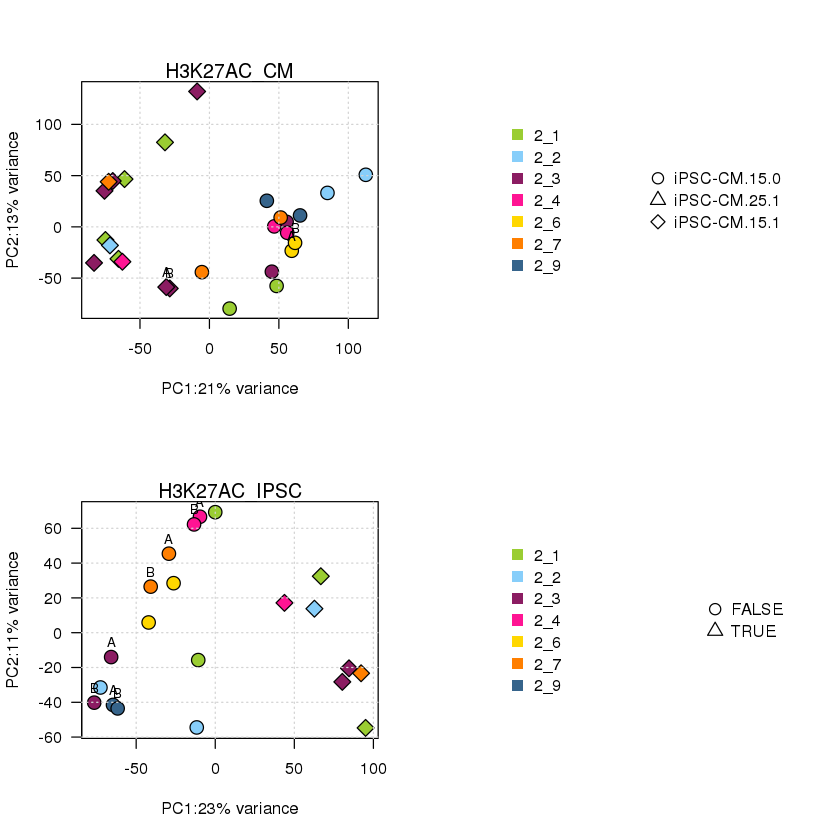

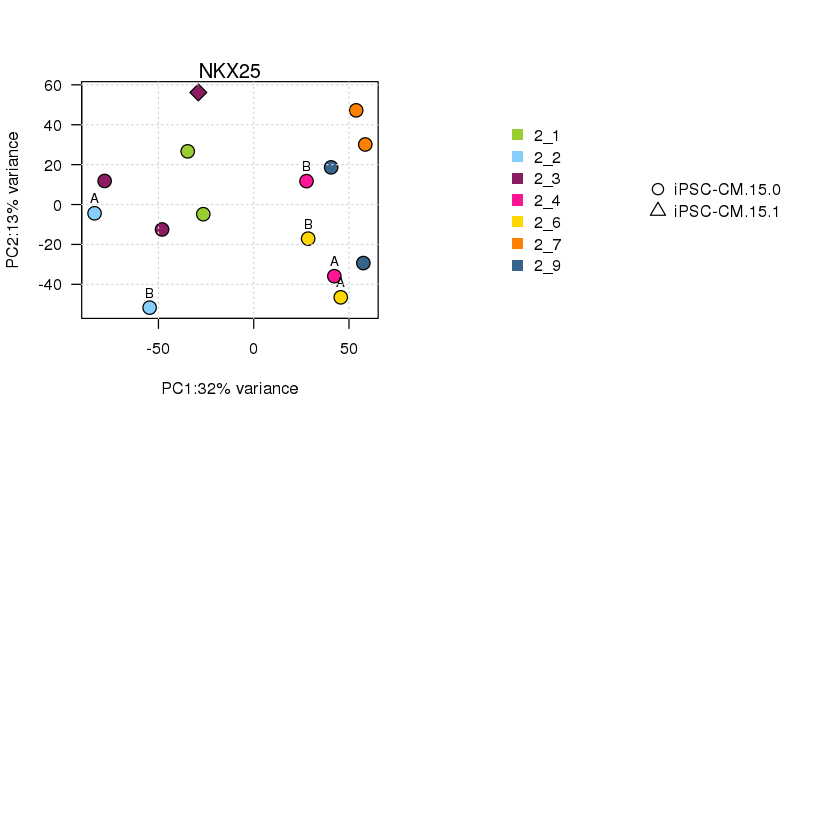

In [76]:
peaks_stats = data.frame()
par(mfrow=c(2,2))
for(i in 1:length(marks)){

    mark=marks[i]
    cat(marks[i], "\n")
    dir.create(mark, showWarnings = FALSE)
    
    mat       = read.table(outfiles[i], row.names=1, header=T, check.names=F,sep="\t")
    mat       = subset(mat,Length<5000 )  ### remove all peaks >5kb
    peak_size = mat$Length
    
    mat     = mat[, c(6:length(mat))]
    samples = subset(samples0, UUID %in% colnames(mat) )
    samples = merge(samples,annot, by="Subject_ID" )
    mat     = subset(mat, select=as.character(samples$UUID)) ### ensure the order
    mat     = mat[order(rowMeans(mat), decreasing=T),]
    
    peaks_stats["#samples",i] = ncol(mat)
    peaks_stats["#peaks",i]   = nrow(mat)
    peaks_stats["avg_size",i] = mean (peak_size)
    peaks_stats["median_size",i] = median (peak_size)
    
#  write.table(mat, paste(mark, "normalized_filtered_counts.txt", sep="/"), row.names=T, col.names=T, sep="\t")
    
   # mat     = mat[1:10000,]
    
    pca <- prcomp(t(mat))
    percentVar <- pca$sdev^2 / sum( pca$sdev^2 )
    
    if( unique(samples$Cell_type)=="iPSC")    { categ     = "iPS_batch_2"}
    if( unique(samples$Cell_type)=="iPSC-CM") { categ    = "Cell_type_2"}

#pdf(paste(mark,"/", mark , "_", "PCA.pdf", sep=""))
   # par(mfrow=c(3,3))

        plot_pca2(1,2,pca,percentVar,samples, as.character(samples$subject.color), 
                  samples$Technical_replicate_ID , c(21,23,23)[as.factor(samples[,categ])] )
#         plot_pca2(1,3,pca,percentVar,samples, as.character(samples$subject.color), 
#                   samples$Technical_replicate_ID , c(21,24,23)[as.factor(samples[,categ])] )
#         plot_pca2(2,3,pca,percentVar,samples, as.character(samples$subject.color), 
#                   samples$Technical_replicate_ID , c(21,24,23)[as.factor(samples[,categ])] )
    mtext(mark)
    plot.new()
            legend("left", pch=15,cex=1,bty = "n",
                   col=unique(as.character(samples$subject.color)), 
                   legend=str_split_fixed(unique(samples$Subject_ID), "iPSCORE_",2)[,2], pt.cex=1.5)
            legend("right", pch= c(21,24,23),cex=1,bty = "n", legend=unique(samples[,categ]), pt.cex=1.5)

#     plot(percentVar[], xlab = "Principal Component",
#              ylab = "Proportion of Variance Explained",
#              type = "b")
#     plot(cumsum(percentVar[]), xlab = "Principal Component",
#               ylab = "Cumulative Proportion of Variance Explained",
#               type = "b")
    
#     hist(peak_size, xlab="peak size", main=mark)
#     abline(v=mean(peak_size), col="red", lwd=2, lty=2)

  # dev.off()
 
   

}

colnames(peaks_stats) = marks 

### PCA association with different vatiables

In [24]:
var_ips = c('iPS_batch', 'Passage', 'ChIP.Seq_ATAC.Seq_FRiP', 'Subject')
var_cm  = c('cTNT', 'cTNT_TPM', 'Cell_type_2' ,'ChIP.Seq_ATAC.Seq_FRiP', 'Subject')
pcs     = c("PC1","PC2" ,"PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")

In [26]:
for(m in 3:length(marks)){

    mark=marks[m]
    cat(marks[m], "\n")
    
    mat     = read.table(paste(mark, "normalized_filtered_counts.txt", sep="/"), row.names=1, header=T, check.names=F)
    samples = subset(samples0, UUID %in% colnames(mat) )
    mat     = subset(mat, select=as.character(samples$UUID)) ### ensure the order
    pca     = prcomp(t(mat))
    percentVar = pca$sdev^2 / sum( pca$sdev^2 )
    
     x =data.frame(pca$x)
     rownames(x)=samples$UUID
     samp_pc = merge(samples, x[,1:10], by.x="UUID", by.y="row.names")
    
   if( unique(samples$Cell_type)=="iPSC")    { variab = samp_pc[, c(pcs, var_ips)]}
   if( unique(samples$Cell_type)=="iPSC-CM") { variab = samp_pc[, c(pcs, var_cm)]}


    p_val<-data.frame()
    variance_expl<-data.frame()
    for (i in 1:10){
        for(j in 11:ncol(variab)){
       
            l<-lm(variab[,i]~variab[,j])
        
            p_val[i,j-10]<-anova(l)[1,5]
        
            variance_expl[i,j-10]<-anova(l)[1,2]/(anova(l)[1,2]+anova(l)[2,2])
            variance_expl[i,j-10]<-summary(l)$adj.r.squared
          
    }
}
    colnames(p_val)<-colnames(variance_expl)<-colnames(variab)[11:ncol(variab)]
    rownames(p_val)<-rownames(variance_expl)<-colnames(variab)[1:10]
    
    my_palette =colorRampPalette( rev(brewer.pal(9, "Blues")) )(10)[8:2]
    #my_palette = colorRampPalette(c( "white","dodgerblue3"))(10)

    m<--log(p_val,10)
    m[m<1.3]<-NA
    rownames(m)<-paste(rownames(p_val),round(percentVar[1:10],2)*100, "%" )
   
pdf(paste(mark,'/',mark,'_', "heatmap_PC_correlations.pdf", sep=""))
    heatmap.2(as.matrix(m) , srtRow=0, srtCol=45, offsetRow=-0.5, offsetCol=-0.5, 
          keysize=1, margins =c(21,23), trace="none",Colv=F,Rowv=F,dendrogram='none',
          key.title="-Log10(P)", cellnote=round(variance_expl,2), notecol="black", 
          cexRow=1, cexCol=1, col=my_palette,
          sepwidth=c(0.01,0.01),sepcolor="black",colsep=0:ncol(m),rowsep=0:nrow(m))

    dev.off()
}    

H3K27AC_CM 
H3K27AC_IPSC 
NKX25 


### Correcting for batches, differentiation efficiency and calculate inter-sample correlation

### Combine plots also RNA-Seq for figure

In [77]:
kin<-read.csv("KINSHIP.csv", row.names=1)

In [78]:
samples0$iPS_batch=as.character(samples0$iPS_batch)

In [79]:
marks = c( "mRNA iPSCs", "mRNA CMs",'H3K27ac iPSCs', 'H3K27ac CMs','NKX2-5 CMs' )

In [80]:
setwd("/frazer01/home/paola/Family1070/private_output/")

In [81]:
exp_table = c(  'PCA_rnaseq/iPSC_29samp/vst_normalized_counts.txt',
                'PCA_rnaseq/iPSC_CM/vst_normalized_counts.txt',
                'PCA_chipseq/H3K27AC_IPSC/normalized_filtered_counts.txt',
                'PCA_chipseq/H3K27AC_CM/normalized_filtered_counts.txt',
                'PCA_chipseq/NKX25/normalized_filtered_counts.txt' )

In [ ]:
#pdf("Figures/Inter_intra_Spearman_beeswarm_after_correction_most_var1k_3.pdf")
par(mfcol=c(3,5), pin = c(1,1.3))
for(m in 1:length(marks)){

    mark=marks[m]
    
    
    mat     = read.table(exp_table[m], row.names=1, header=T, check.names=F)
    samples = droplevels(subset(samples0, UUID %in% colnames(mat) ))
    samples = merge(samples,annot, by="Subject_ID" )
    
#     pca     = prcomp(t(mat))
#     x =data.frame(pca$x)
#     rownames(x)=samples$UUID
#     samples = merge(samples, x[,1:3], by.x="UUID", by.y="row.names")
    
    mat     = subset(mat, select=as.character(samples$UUID)) ### ensure the order

    
    if( m==1)    { 
        fit <- lmFit( mat, model.matrix(~ iPS_batch, samples))}
    
    if( m==2) { 
        fit <- lmFit( mat, model.matrix(~cTNT_TPM + Cell_type_2 , samples))}


    if( m==3)    { 
        fit <- lmFit( mat, model.matrix(~ iPS_batch +ChIP.Seq_ATAC.Seq_FRiP , samples))}
    
    if( m==4) { 
        fit <- lmFit( mat, model.matrix(~cTNT_TPM + Cell_type_2 + ChIP.Seq_ATAC.Seq_FRiP, samples))}

     if( m==5) { 
        fit <- lmFit( mat, model.matrix(~cTNT_TPM + Cell_type_2 + ChIP.Seq_ATAC.Seq_FRiP, samples))}

    

    res <- residuals(fit, mat)
    mat_corrected<- res + rowMeans(as.matrix(mat))
    
 #   mat_corrected = as.matrix(mat)
    mat_corrected = mat_corrected[order(rowVars(mat_corrected),decreasing=T),]
    # mat_corrected = mat_corrected[order(rowMeans(mat_corrected),decreasing=T),]
    mat_corrected = mat_corrected[1:1000,]

    cormat<-cor(mat_corrected, method="spearman")
    colnames(cormat)<-rownames(cormat)<- samples$New_label
    
    
kin_mat<-matrix(NA,nrow(cormat),nrow(cormat) )
samples$subj_names=make.unique(as.character((samples$Subject)))
colnames(kin_mat)<-rownames(kin_mat)<-samples$subj_names

for(i in 1:nrow(cormat)){
    for(j in 1:ncol(cormat)){
        kin_mat[i,j]<-kin[as.character(samples$Subject[samples$subj_names==rownames(kin_mat)[i]]) ,
                          as.character(samples$Subject[samples$subj_names==colnames(kin_mat)[j]])  ]    
    }
}

cormat[cormat==1]<-NA   ## eliminate same sample comparisons

    
##### eliminate comparisons between technical replicates    
rep_mat<-matrix(NA,nrow(cormat),nrow(cormat) )
samples$subj_names=make.unique(as.character((samples$Subject)))
colnames(rep_mat)<-rownames(rep_mat)<-samples$subj_names

for(i in 1:nrow(cormat)){
    for(j in 1:ncol(cormat)){
        rep_mat[i,j]<-samples$Technical_replicate_ID[samples$subj_names==samples$subj_names[i]]%in% c('A','B')&
                       samples$Technical_replicate_ID[samples$subj_names==samples$subj_names[j]]%in% c('A','B')&
        samples$Subject_ID[i] == samples$Subject_ID[j]
    }
}
   
cormat[rep_mat==1]<-NA    
    
    
    
####### Test all samples comparting same and different genetic background
test0<-cormat
test0[kin_mat!=0]<-NA
test1<-cormat
test1[kin_mat!=1]<-NA
test2<-cormat
test2[kin_mat!=2]<-NA
test3<-cormat
test3[kin_mat==0]<-NA

same     = rowMeans(test0, na.rm=T)
same     = same[!duplicated(same)]  # this is to ensure that when there are only two reps per sample they are counted twice
related  = rowMeans(test1, na.rm=T)
unrelated = rowMeans(test2, na.rm=T)
unrelated = unrelated[!is.na(unrelated)]
different = rowMeans(test3, na.rm=T)

    tricols<-c("gray40","gray80", "gray99")
##### Plot1 = relationships dots
#     beeswarm(list(same, related, unrelated), 
#           log = F, pch = 21, bg = tricols,corral="random", las=1, labels=c("same", "related", "unrelated"),
#          xlab=paste(signif(wilcox.test(related, same, alternative="less", paired=F ) $p.value ,2),
#                    signif(wilcox.test(unrelated, same, alternative="less", paired=F ) $p.value ,2),
#                    signif(wilcox.test(unrelated, related, alternative="less", paired=F ) $p.value ,2)), main=mark)
#     bxplot(list(same, related, unrelated), add = TRUE)

##### Plot2 = bio-rep dots
    
    beeswarm(list(same, different), 
    log    = F, pch = 21, bg = tricols,corral="random", las=1, 
    labels = c(paste("n", sum(!is.na(same)), sep="="), paste("n", sum(!is.na(different)), sep="=")),
    xlab   = paste("P=", signif(wilcox.test(different, same, alternative="less", paired=F ) $p.value ,3))
             , main=mark)
    bxplot(list(same,different ), add = TRUE)

##### Plot3 = relationships - violins
    
    low=min(c(same,related,unrelated),na.rm=T)
    top=max(c(same,related,unrelated),na.rm=T)
    extra=(top-low)/4
    ylim=c(low-extra,top+extra)

    plot(0,0,type="n",xlim=c(0.5,3.5), ylim=ylim,  xaxt = 'n', ylab="pair-wise correlation", las=1,
            xlab = paste("same", "related", "unrelated"))

    vioplot(na.omit(same), at = 1, add = T, col =tricols[1] )
    vioplot(na.omit(related), at = 2, add = T, col = tricols[2])
    vioplot(na.omit(unrelated), at = 3, add = T, col = tricols[3])
    axis(side=1,at=1:3,labels=c(sum(!is.na(same)), sum(!is.na(related)),sum(!is.na(unrelated))  ))

plot.new()
    pvals = paste( "P=",signif(wilcox.test(related, same, alternative="less", paired=F ) $p.value ,2),
                "\nP=",signif(wilcox.test(unrelated, same, alternative="less", paired=F ) $p.value ,2),
                "\nP=",signif(wilcox.test(unrelated, related, alternative="less", paired=F ) $p.value ,2))
    legend("center", legend=pvals, bty="n")
    }
#dev.off()